# compensating saturated pulses

## Intro

orthogonal decomposition for recovering linear behavior from saturated pulses

## Loading Libraries

In [1]:
from pylab import *
import h5py
from scipy.optimize import curve_fit
#from scipy.stats import binned_statistic_dd
from scipy.stats import binned_statistic_dd
from scipy import optimize
import pickle
from scipy import stats
from scipy.stats.mstats import theilslopes
from scipy.signal import medfilt
from scipy.signal import savgol_filter
import os
from scipy import ndimage

## Initializing Data

### Loading Data

In [2]:
#load data
experiment_run_name = "sxrls6516run166.h5"
my_file = experiment_run_name
my_hdf5_object = h5py.File(my_file,"r")

In [3]:
#convert hdf5 to dict
my_list = []
def func(name, obj):
    my_list.append(name)

my_hdf5_object.visititems(func)
my_dict = {}
for i in my_list:
    try:
        my_dict[i] = array(my_hdf5_object[i])
    except AttributeError:
        print(i)
        
pixel_to_femtosecond_list = []
width_list = []
my_hdf5_object.close()

evr


In [4]:
apd_traces = my_dict['acq01/ch2'] - dot(array([mean(my_dict['acq01/ch2'][:,:50],axis=1)]).transpose(),array([ones(my_dict['acq01/ch2'].shape[1])]))
mcp_traces = my_dict['acq01/ch3'] - dot(array([mean(my_dict['acq01/ch3'][:,:50],axis=1)]).transpose(),array([ones(my_dict['acq01/ch3'].shape[1])]))

## Visualizing Some Sample Data from the high speed digitizer (hsd)

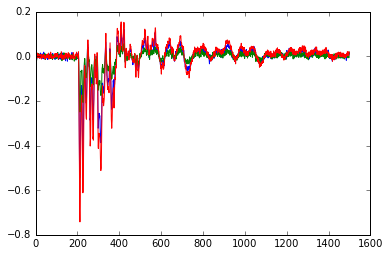

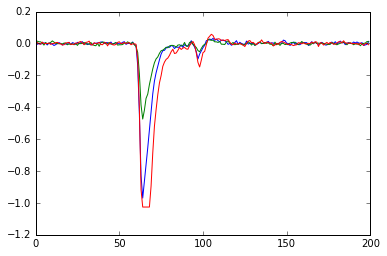

In [5]:
plot(mcp_traces[0])
plot(mcp_traces[400])
plot(mcp_traces[800])
show()

plot(apd_traces[0])
plot(apd_traces[400])
plot(apd_traces[800])
show()

In [6]:
def moment(x,y):
    return sum()

ndimage.measurements.center_of_mass(mcp_traces[0])
ndimage.measurements.center_of_mass(apd_traces[0])

(65.090820039182759,)

#### aligning waveforms

In [9]:
ch1_waves = 0+apd_traces[:100000]
temp = ch1_waves[0]
for j,i in enumerate(ch1_waves):
    #shift_amount = 6352-argmax(convolve(ch1_waves[0],i))+100
    shift_amount = 75-argmax(convolve(diff(ch1_waves[0]),diff(i)))+125
    try:
        temp = vstack([temp,append(zeros(shift_amount),i[:-shift_amount])])
    except ValueError:
        shift_amount = 75-argmax(convolve(diff(ch1_waves[0]),diff(ch1_waves[j-300])))+125
        temp = vstack([temp,append(zeros(shift_amount),i[:-shift_amount])])

temp =temp[1:]
    

KeyboardInterrupt: 

In [10]:
j

16464

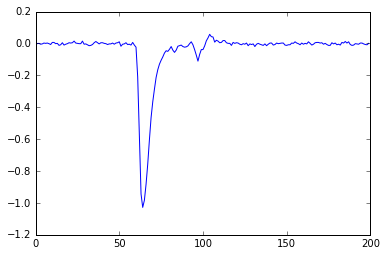

In [11]:
plot(ch1_waves[j-1])
show()

In [12]:
ch1_waves = temp

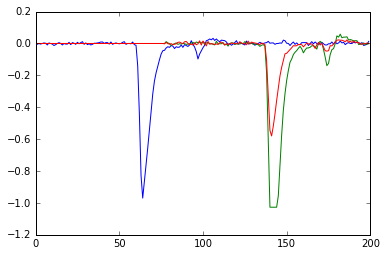

In [13]:
plot(ch1_waves[0])
plot(ch1_waves[400])
plot(ch1_waves[800])
#xlim(115,130)
show()

#### identifying saturated waveforms

In [14]:
non_saturated_pulses = array([(0.8>max(abs(i)) and 0.3<max(abs(i))) for i in ch1_waves])

In [15]:
sum(non_saturated_pulses)

3715

/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.2.9-py3/lib/python3.5/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 16465 but corresponding boolean dimension is 100
  if __name__ == '__main__':


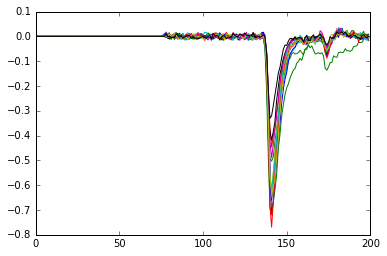

In [17]:
for i in ch1_waves[non_saturated_pulses[:100]]:
    plot(i)
show()

### Calculating Eiegen Waveform using SVD on manually selected non-saturated peaks

In [18]:
##############################
##############################
#singular value decomposition on background shots. variable v contains the eigen backgrounds
#u,s,v = svd(ch0_waves) don't use this. it will crash computer unless a small section of the waveforms is chosen
##############################
##############################


#instead manually calculate svd by using the smaller lh sv.
s,u = eig(dot(ch1_waves[non_saturated_pulses].transpose(),ch1_waves[non_saturated_pulses]))
v = u.transpose()



In [19]:
dot(ch1_waves[non_saturated_pulses].transpose(),ch1_waves[non_saturated_pulses]).shape

(200, 200)

In [20]:
temp = array([i/dot(i,i)**0.5 for i in v[:25]])#normalizing
v = real(temp)
print(dot(v[0],v[0])) #validating orthogonality
print(dot(v[1],v[1])) #validating orthogonality
print(dot(v[0],v[1])) #validating orthogonality
print(dot(v[0],v[2])) #validating orthogonality
print(dot(v[1],v[2])) #validating orthogonality

1.0
1.0
2.77555756156e-17
-2.77555756156e-16
-6.09234884763e-15


####  eigen waveforms and kolmogorov smironv test

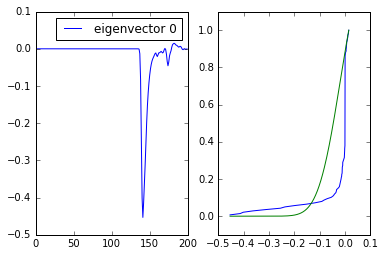

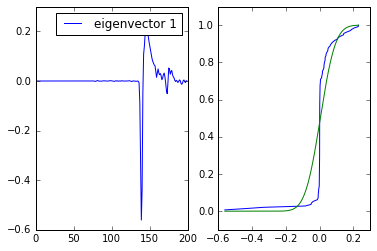

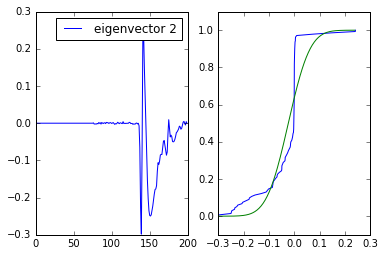

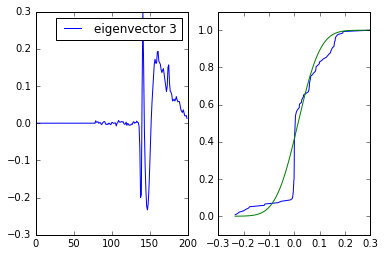

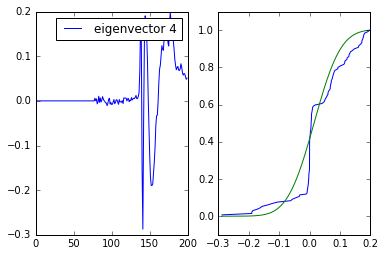

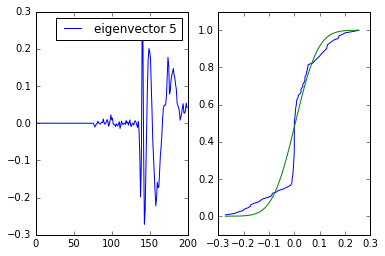

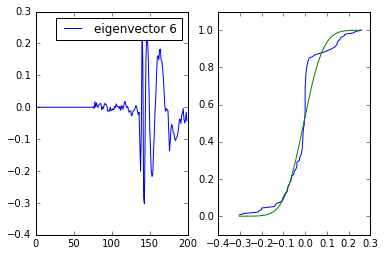

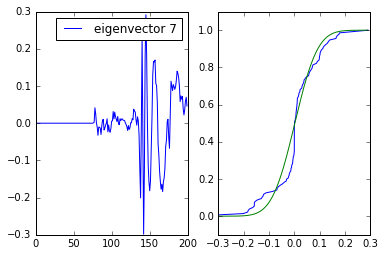

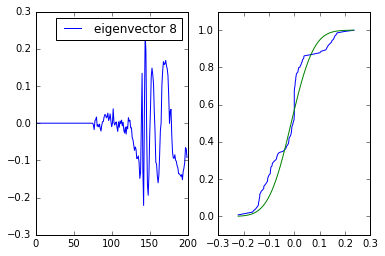

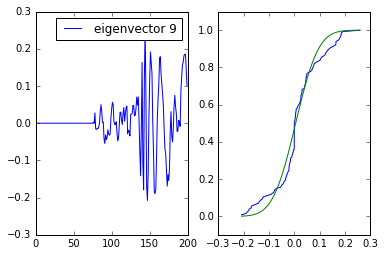

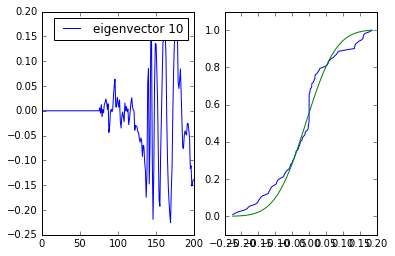

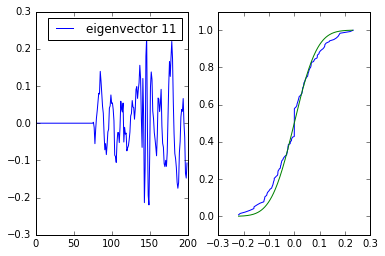

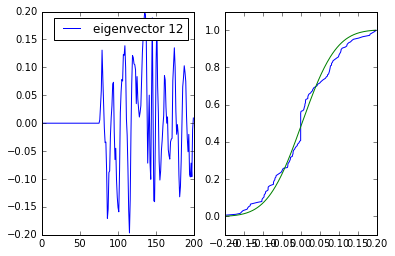

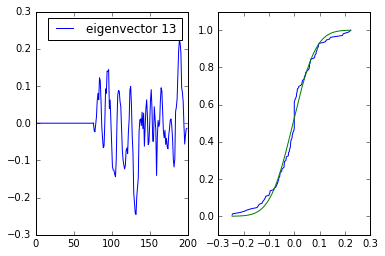

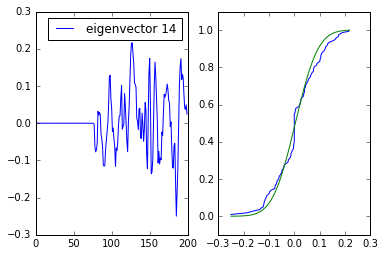

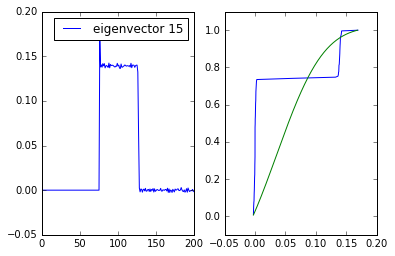

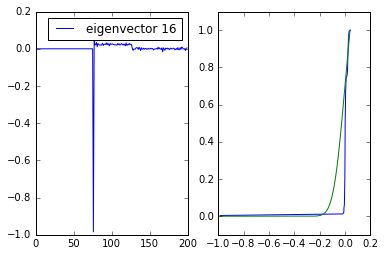

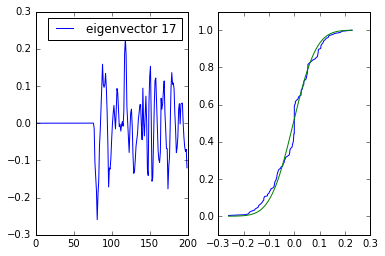

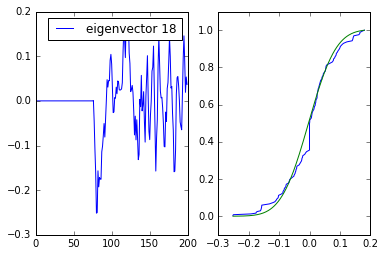

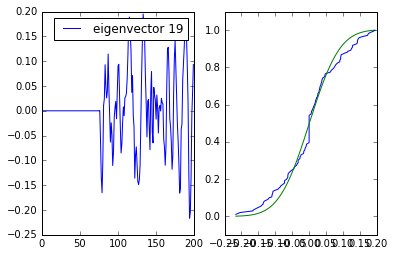

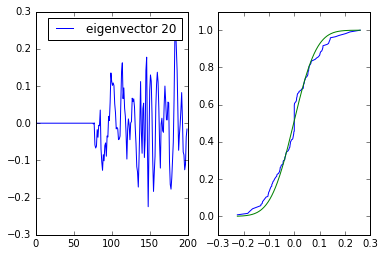

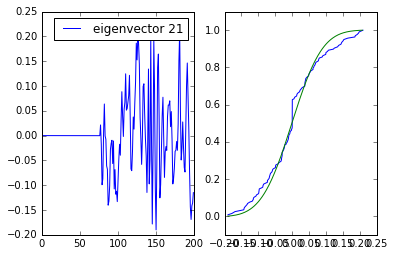

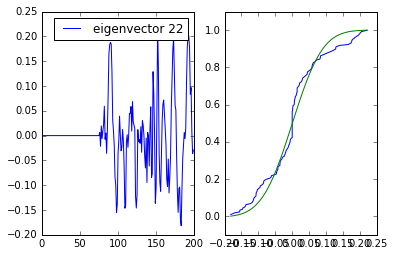

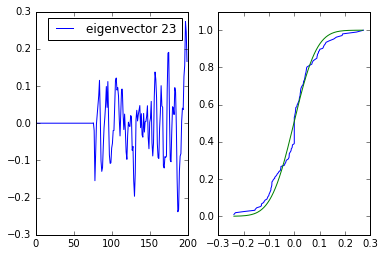

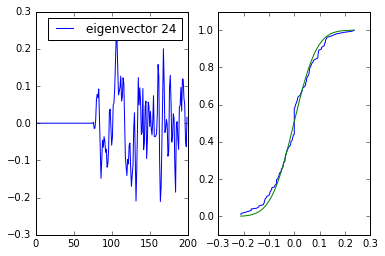

In [21]:
#showing some of the eigen backgrounds
#higher order eigen vectors have gaussian distribution.
#kolmogorov smirnov test isn't implemented accurately here.
#also, anderson-darling and shapiro-wilk test supposed to be more robust
counter = 0
for i in v:
    subplot(121)
    plot(i)
    legend(["eigenvector "+str(counter)])
    
    subplot(122)
    my_edf = cumsum(argsort(i))
    my_edf=my_edf/max(my_edf)
    plot(sort(i),my_edf)
    ylim(-0.1,1.1)
    my_mean = mean(i)
    #my_mean = (max(i)+min(i))/2
    my_std = std(i)
    x = arange(min(i),max(i),(max(i)-min(i))/len(i))
    y = cumsum(exp(-(((x-my_mean)/(2**0.5*my_std))**2)))
    y = y / max(y)
    plot(x,y)
    
    counter = counter+1
    show()


### redoing reconstruction by masking saturated regions.

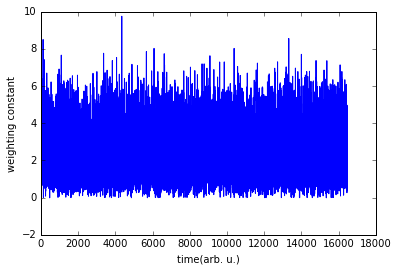

In [22]:
#start,end = (2000,2400)  #which section of waveform to use for svd.  use to select out saturation region
my_mask = ones(ch1_waves.shape[1])
my_mask[122:130]=0
#my_mask[:]=1.0
my_mask = my_mask.astype(bool)

eig_size = 10

#calculating and showing the weights. x-axis is event number
#my_weights = real(dot(ch1_waves[:,my_mask],v[:6,my_mask].transpose()))
my_weights = []


for i in ch1_waves:

    my_mask = abs(i)<0.9
    pseudo_inv = dot(inv(dot(v[:eig_size,my_mask],v[:eig_size,my_mask].transpose())),v[:eig_size,my_mask])

    #total 
    my_weights.append(dot(pseudo_inv,i[my_mask]))

my_weights = array(my_weights)
                    
plot(my_weights[:,0])#the weight of each event
xlabel("time(arb. u.)")
ylabel("weighting constant")
show()

15684


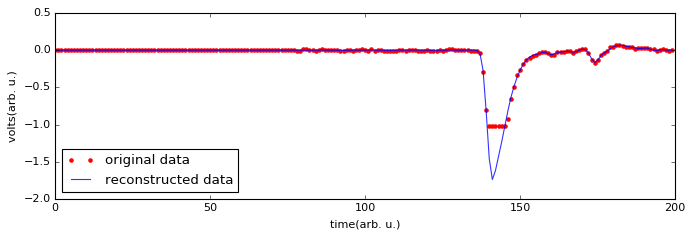

15939


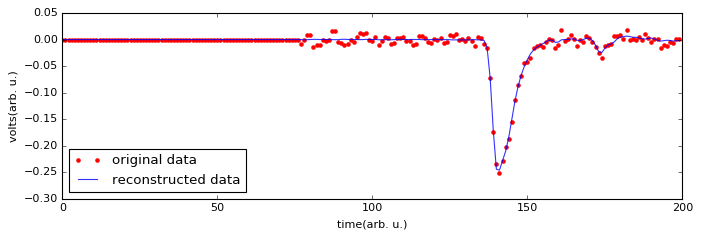

1144


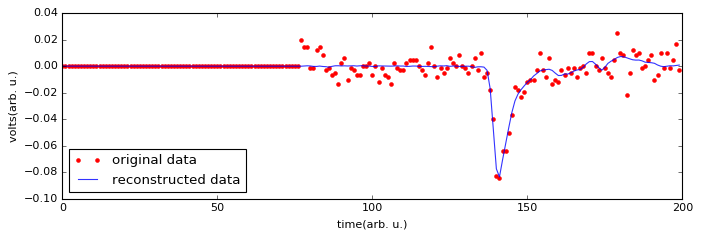

14230


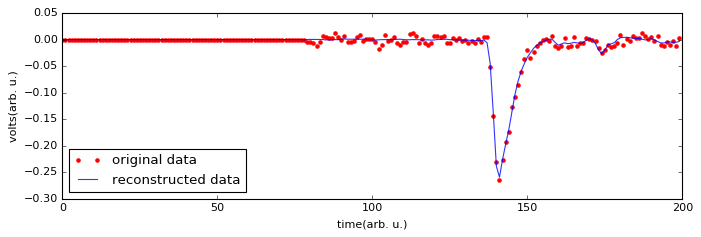

14223


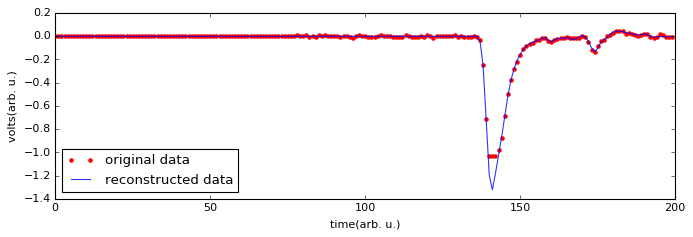

3912


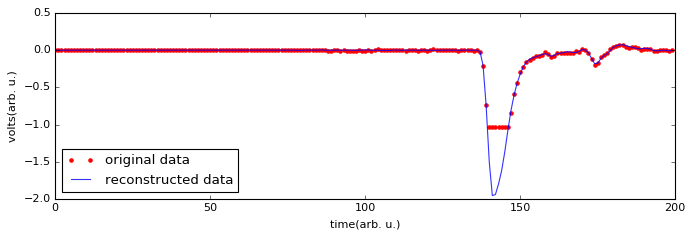

11478


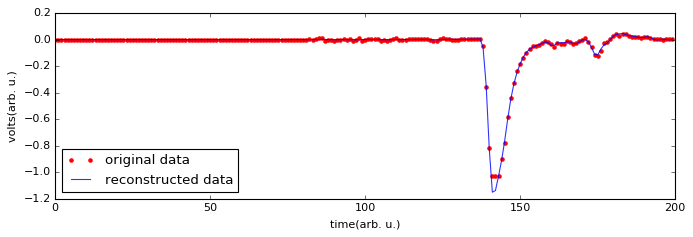

713


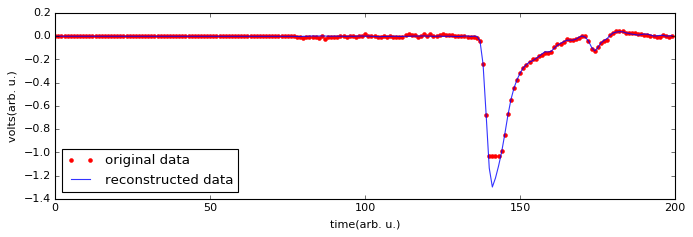

6903


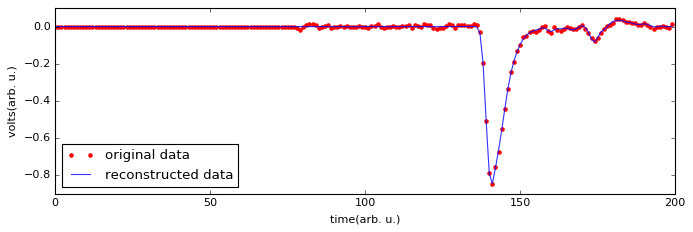

3813


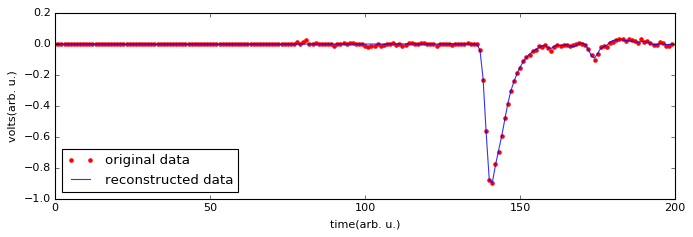

5408


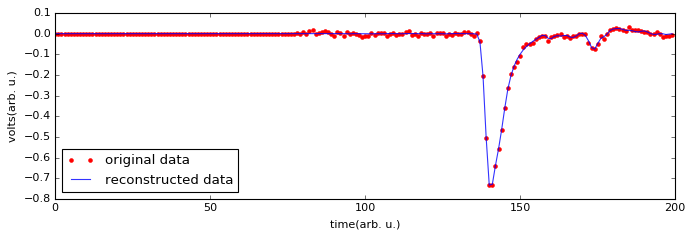

12675


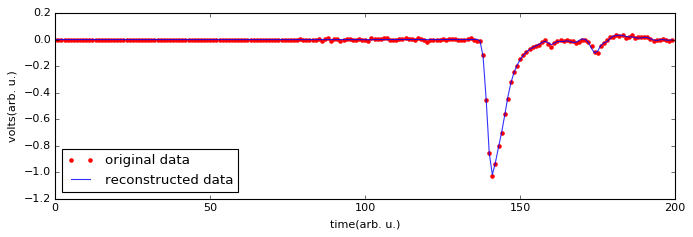

12140


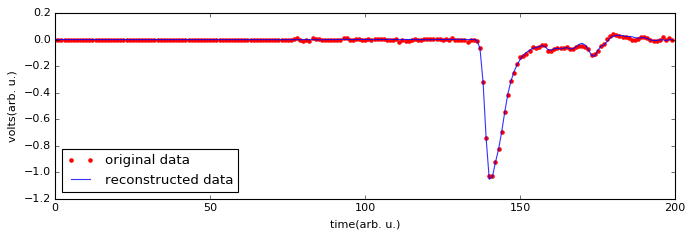

9843


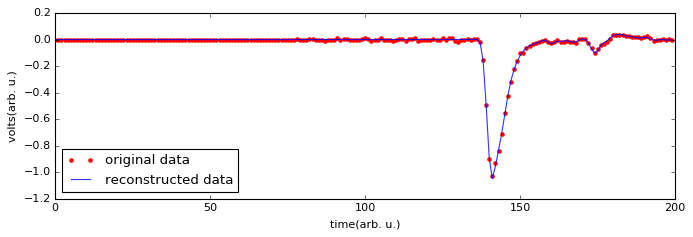

14011


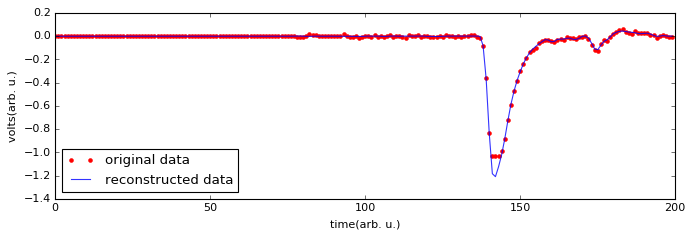

4166


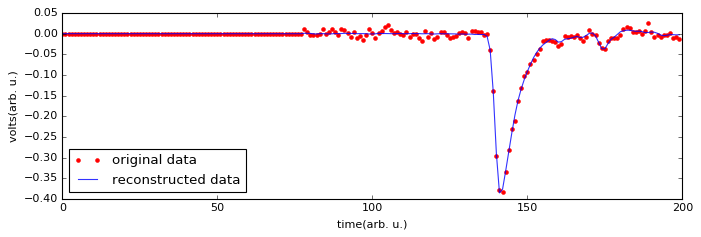

13857


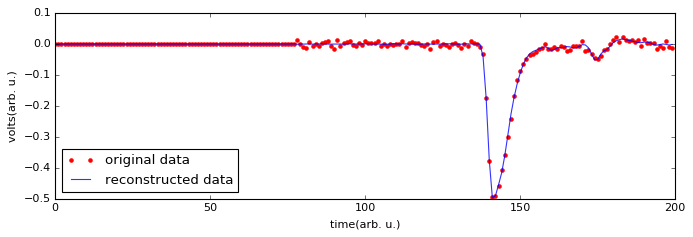

16296


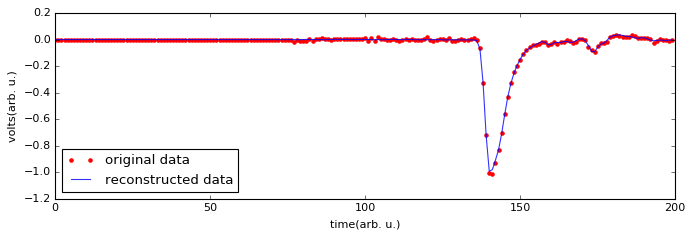

15595


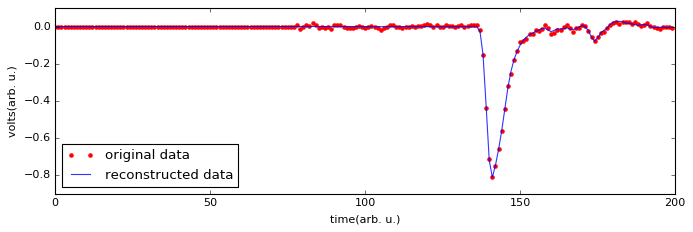

7457


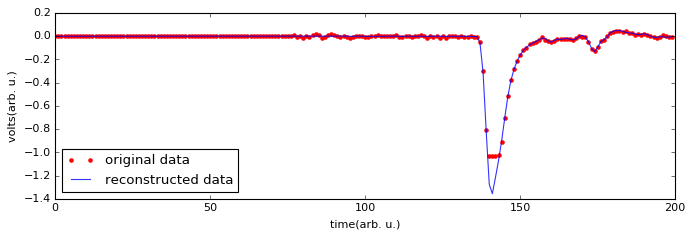

In [23]:
#saturated needs more finesse. doesn't work straight out of the box
for i in (rand(20)*len(my_weights)).astype(int):
    event_to_reconstruct=i
    reconstructed = sum(my_weights[event_to_reconstruct][i]*v[i] for i in arange(eig_size)) #0th waveform calculated from first 5 eigen waveforms
    fig=plt.figure(figsize=(10, 3), dpi= 80, facecolor='w', edgecolor='k')
    plot(ch1_waves[event_to_reconstruct],'r.',markersize=7) #original data set
    plot(reconstructed,'-',alpha=0.8,markersize=9)
    #xlim(3225,3325)
    #xlim(5150,5250)
    xlabel("time(arb. u.)")
    ylabel("volts(arb. u.)")
    legend(['original data','reconstructed data'],loc=3)
    print(i)
    show()

7457


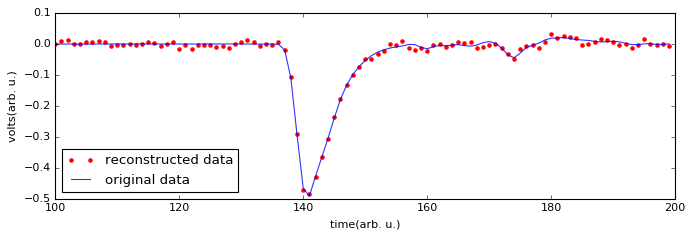

In [24]:
event_to_reconstruct=165
reconstructed = sum(my_weights[event_to_reconstruct][i]*v[i] for i in arange(eig_size)) #0th waveform calculated from first 5 eigen waveforms
fig=plt.figure(figsize=(10, 3), dpi= 80, facecolor='w', edgecolor='k')
plot(ch1_waves[event_to_reconstruct],'r.',markersize=7) #original data set
plot(reconstructed,'-',alpha=0.8,markersize=9)
#xlim(3225,3325)
#xlim(5150,5250)
xlabel("time(arb. u.)")
ylabel("volts(arb. u.)")
legend(['reconstructed data','original data'],loc=3)
xlim(100,200)
print(i)
show()

## Comparing Linearity

### no correction linearity

In [80]:
off_by_one=1
apd_pulse_start,apd_pulse_end = 50,100
apd_recon_start,apd_recon_end = 110,175


apd_reconstructed_traces = dot(my_weights,v[:10])




my_edges = array([0,0.5,1,2,3,6,9,12,15,18,21,24,27,30,36,45,55])
mcp_qsum,apd_qsum = sum(mcp_traces**2,axis=1),sum(apd_traces[:,apd_pulse_start:apd_pulse_end]**2,axis=1)


apd_reconstructed_sum = sum(apd_reconstructed_traces[:,apd_recon_start:apd_recon_end]**2,axis=1)[off_by_one:]
my_hist = binned_statistic_dd(mcp_qsum,apd_qsum,bins=[my_edges],statistic=mean)
my_recon_hist = binned_statistic_dd(mcp_qsum[:apd_reconstructed_sum.shape[0]],apd_reconstructed_sum,bins=[my_edges],statistic=mean)


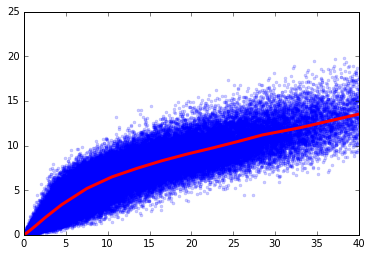

In [148]:
plot(mcp_qsum,apd_qsum,'.',alpha=0.2)
plot((my_hist.bin_edges[0][:-1]+my_hist.bin_edges[0][1:])/2,my_hist.statistic,'r',linewidth=3)
ylim(0,25)
xlim(0,40)
show()

### naive censoring

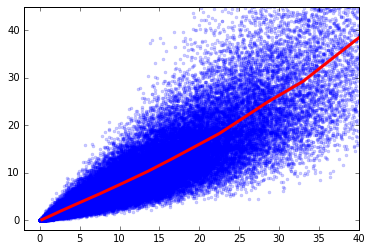

In [159]:
my_size = 70000
off_by_one = 1
plot(mcp_qsum[:apd_reconstructed_sum.shape[0]][:my_size],apd_reconstructed_sum[:my_size],'.',alpha=0.2)
plot((my_recon_hist.bin_edges[0][:-1]+my_recon_hist.bin_edges[0][1:])/2,my_recon_hist.statistic,'r',linewidth=3)
ylim(-2,45)
xlim(-2,40)
show()

### energy correction

In [487]:
theta = my_dict['theta'][:apd_reconstructed_sum.shape[0]][:my_size]
energy = my_dict['ebeam/photon_energy'][:apd_reconstructed_sum.shape[0]]

energy_edges = arange(935,942,.25)
theta_edges = arange(41,53,0.4)
scatter_energy = binned_statistic_dd(energy,(apd_reconstructed_sum/mcp_qsum[:apd_reconstructed_sum.shape[0]]),bins=[energy_edges],statistic=mean)
scatter_theta = binned_statistic_dd(my_dict['theta'][:apd_reconstructed_sum.shape[0]],(apd_reconstructed_sum/mcp_qsum[:apd_reconstructed_sum.shape[0]]),bins=[theta_edges],statistic=mean)

scatter_theta_energy = binned_statistic_dd([energy,my_dict['theta'][:apd_reconstructed_sum.shape[0]]],(apd_reconstructed_sum/mcp_qsum[:apd_reconstructed_sum.shape[0]]),bins=[energy_edges,theta_edges],statistic=mean)

#binned_statistic_dd(mcp_qsum,apd_qsum,bins=[my_edges],statistic=mean)


In [488]:
theta_edges

array([ 41. ,  41.4,  41.8,  42.2,  42.6,  43. ,  43.4,  43.8,  44.2,
        44.6,  45. ,  45.4,  45.8,  46.2,  46.6,  47. ,  47.4,  47.8,
        48.2,  48.6,  49. ,  49.4,  49.8,  50.2,  50.6,  51. ,  51.4,
        51.8,  52.2,  52.6])

In [489]:
min(theta)

41.0

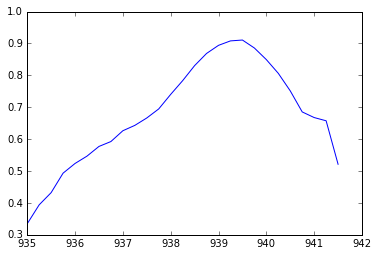

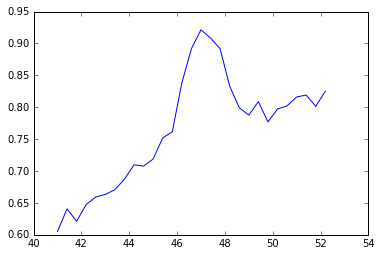

In [490]:
plot(scatter_energy.bin_edges[0][:-1],scatter_energy.statistic,'-')
show()
plot(scatter_theta.bin_edges[0][:-1],scatter_theta.statistic,'-')
show()

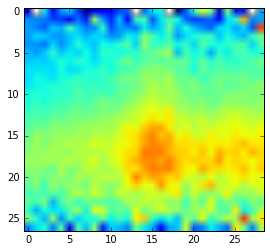

1.2077627667959929

In [491]:
imshow(scatter_theta_energy.statistic)
clim(0,1.4)
show()
max(nan_to_num(scatter_theta_energy.statistic.flatten()))

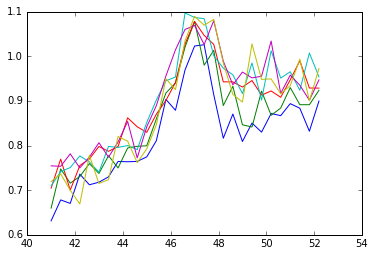

In [496]:
for i in arange(14,20,1):
    try:
        plot(scatter_theta_energy.bin_edges[1][:-1], scatter_theta_energy.statistic[i])
    except:
        pass
show()

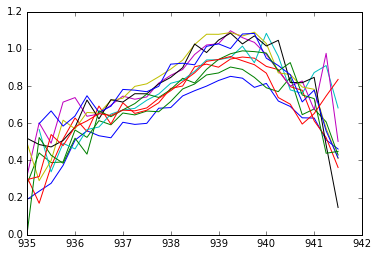

In [503]:
for i in arange(10,20,1):
    try:
        plot(scatter_theta_energy.bin_edges[0][:-1], scatter_theta_energy.statistic[:,i])
    except:
        pass
show()

In [497]:
u,s,v = svd(scatter_theta_energy.statistic[13:22])

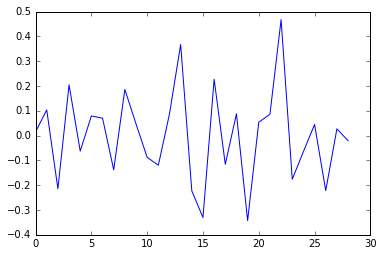

In [499]:
plot(-v[1])
show()

In [504]:
energy = my_dict['ebeam/photon_energy'][:my_size][:apd_reconstructed_sum.shape[0]]
theta = my_dict['theta'][:apd_reconstructed_sum.shape[0]][:my_size]

my_mask = theta[:my_size]>42
my_mask *= theta[:my_size]<44

my_mask *= energy>936
my_mask *= energy<938

theta = my_dict['theta'][:apd_reconstructed_sum.shape[0]][:my_size][my_mask]
energy = my_dict['ebeam/photon_energy'][:apd_reconstructed_sum.shape[0]][my_mask]

y = apd_reconstructed_sum[:my_size][my_mask]
x = mcp_qsum[:apd_reconstructed_sum.shape[0]][:my_size][my_mask]


theta_x_product = (theta-mean(theta))*(x-mean(x))
energy_x_product = (energy[:my_size]-mean(nan_to_num(energy[:my_size])))*(x-mean(x))
energy2_x_product = (energy[:my_size]-mean(energy[:my_size]))**2*(x-mean(x))
#fee_energy_gmd_product = (fee-mean(fee))*(x-mean(x))*(energy-mean(energy))
temp_array = nan_to_num(array([ones(len(x)),x,nan_to_num(energy[:my_size]),energy_x_product,theta,theta_x_product]).transpose())
pseudo_inv = dot(inv(dot(temp_array.transpose(),temp_array)),array(temp_array).transpose())
beta = dot(pseudo_inv,y-mean(y))

/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.2.9-py3/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in greater
/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.2.9-py3/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in less
/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.2.9-py3/lib/python3.5/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 74044 but corresponding boolean dimension is 70000


In [505]:
y_corrected = y-dot(temp_array[:,2:]-mean(temp_array[:,2:],axis=0),beta[2:])

In [506]:
y.shape

(3552,)

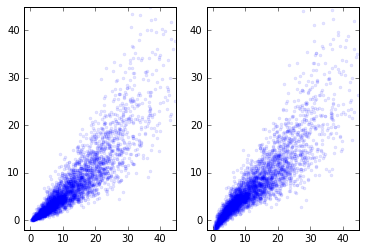

In [507]:
subplot(121)
plot(x,y,'.',alpha=0.1)
ylim(-2,45)
xlim(-2,45)
subplot(122)
plot(x,y_corrected,'.',alpha=0.1)
ylim(-2,45)
xlim(-2,45)
show()

### ad hoc censoring

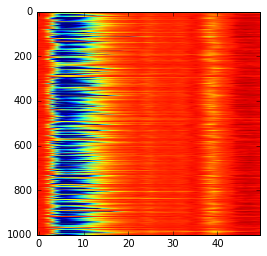

In [100]:
imshow(apd_traces[:,apd_pulse_start:apd_pulse_end],aspect=1.0/20)
show()

In [161]:
sorted_waves = apd_traces[:,apd_pulse_start:apd_pulse_end]
row_sorting = argsort(sum(sorted_waves,axis=1))

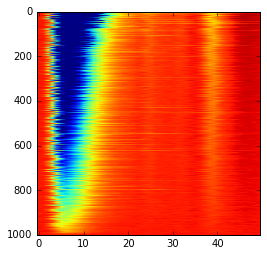

In [162]:
imshow(sorted_waves[row_sorting],aspect=1.0/20)
show()

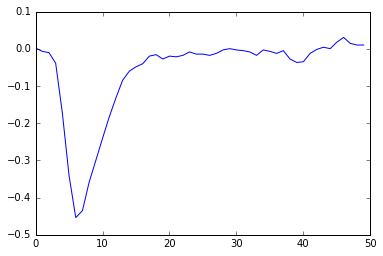

In [163]:
plot(sorted_waves[row_sorting][900])
show()

In [144]:
col_sorting = argsort(sum(sorted_waves[row_sorting],axis=0))

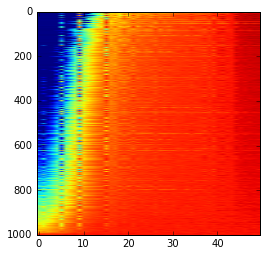

In [171]:
imshow(sorted_waves[row_sorting][:,col_sorting],aspect=1.0/20)
show()

In [172]:
sorted_waves = sorted_waves[row_sorting][:,col_sorting]

In [173]:
my_min = min(sorted_waves.flatten())

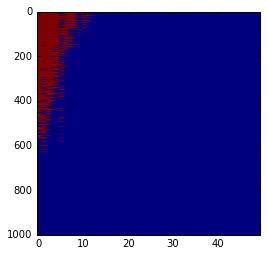

In [176]:
imshow((my_min*0.975>sorted_waves),aspect=1.0/20)
show()

In [177]:
data_matrix = apd_traces[:,apd_pulse_start:apd_pulse_end]

In [187]:
sum(my_min*0.990>sorted_waves)

2688

In [188]:
sum(my_min*0.990>sorted_waves)/(sorted_waves.shape[0]*sorted_waves.shape[1])

0.053760000000000002

In [196]:
2688/8

336.0

In [180]:
sorted_waves.shape

(1000, 50)

In [ ]:
def sort_matrix(my_matrix)
    
    sorting_index
        
    return 